# Analysis of Viking spectrometer data

The Viking spectrometer is typically used with an Andor Newton CCD to record the transmitted FEL spectrum. The `Viking` class of the SCS ToolBox contains all the details about the experiment, but no data. It allows the calculation of an absorption spectrum based on averaged spectra with and without sample (reference).

All the parameters need to be carefully calibrated whenever the spectrometer is moved, usually at the beginning of a beamtime.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True
#%matplotlib notebook
import toolbox_scs as tb

## Setting the stage

In [3]:
proposal = 2953
runNB = 321  # run containing the data with sample
refNB = 322  # run containing the data without sample
darkNB = 375  # dark run

In [4]:
v = tb.Viking(proposal)
v.FIELDS += ['XTD10_SA3']  # add the pulse energy measured by XGM in the XTD10 tunnel
v.X_RANGE = slice(0, 1500) # define the dispersive axis range of interest (in pixels)
v.Y_RANGE = slice(29, 82) # define the non-dispersive axis range of interest (in pixels)
v.ENERGY_CALIB = [1.47802667e-06, 2.30600328e-02, 5.15884589e+02] # energy calibration, see further below
v.BL_POLY_DEG = 1 # define the polynomial degree for baseline subtraction
v.BL_SIGNAL_RANGE = [500, 545] # define the range containing the signal, to be excluded for baseline subtraction

v.load_dark(darkNB)  # load a dark image (averaged over the dark run number)

## Loading data

In [5]:
ds_ref = v.from_run(refNB)  # load refNB. The `newton` variable contains the CCD images.
v.integrate(ds_ref)  # integrate over the non-dispersive dimension 
v.removePolyBaseline(ds_ref)  # remove baseline
ds_ref

<xarray.Dataset>
Dimensions:            (newt_x: 1500, newt_y: 53, pulse_slot: 2700, sa3_pId: 43, trainId: 661)
Coordinates:
  * trainId            (trainId) uint64 1473952798 1473952800 ... 1473954118
  * sa3_pId            (sa3_pId) int64 1056 1088 1120 1152 ... 2336 2368 2400
  * newt_x             (newt_x) float64 515.9 515.9 515.9 ... 553.7 553.7 553.8
Dimensions without coordinates: newt_y, pulse_slot
Data variables:
    bunchPatternTable  (trainId, pulse_slot) uint32 2146089 2048 ... 16777216
    newton             (trainId, newt_y, newt_x) float64 943.0 800.0 ... 758.0
    XTD10_SA3          (trainId, sa3_pId) float64 1.674e+03 ... 1.465e+03
    spectrum           (trainId, newt_x) float64 941.8 960.7 ... 1.319e+03
    spectrum_nobl      (trainId, newt_x) float64 -25.84 -7.063 ... -41.9 -25.1
Attributes:
    runFolder:                 /gpfs/exfel/exp/SCS/202202/p002953/raw/r0322
    vbin::                     4
    hbin:                      1
    startX:                    1
    endX:                      2048
    startY:                    1
    endY:                      512
    temperature:               -50.04199981689453
    high_capacity:             0
    exposure_s:                0.0004
    gain:                      2
    photoelectrons_per_count:  2.05

## Plotting baseline subtracted spectrum

There is often a broad spectral background added to the SASE spectra that needs to be removed. To do so, a polynomial of degree `BL_POLY_DEG` is fitted to the baseline. The ranges where the actual SASE signal is present are avoided by setting the `BL_SIGNAL_RANGE` parameter.

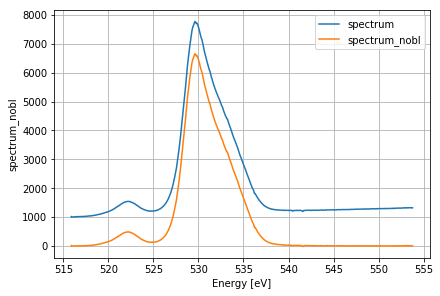

In [6]:
plt.figure()
ds_ref['spectrum'].mean(dim='trainId').plot(label='spectrum')
ds_ref['spectrum_nobl'].mean(dim='trainId').plot(label='spectrum_nobl')
plt.legend()
plt.xlabel('Energy [eV]')
plt.grid()

## Calculating and plotting XAS spectrum

<xarray.Dataset>
Dimensions:                (newt_x: 1500)
Coordinates:
  * newt_x                 (newt_x) float64 515.9 515.9 515.9 ... 553.7 553.8
Data variables:
    It                     (newt_x) float64 3.919 -2.476 ... 0.01703 -2.786
    It_std                 (newt_x) float64 46.04 43.49 44.08 ... 33.76 35.61
    It_stderr              (newt_x) float64 1.852 1.75 1.773 ... 1.358 1.433
    I0                     (newt_x) float64 8.241 -13.35 -7.251 ... 1.327 -4.828
    I0_std                 (newt_x) float64 46.04 43.49 44.08 ... 33.76 35.61
    I0_stderr              (newt_x) float64 1.852 1.75 1.773 ... 1.358 1.433
    absorptionCoef         (newt_x) float64 0.7433 1.685 nan ... 4.356 0.5499
    absorptionCoef_std     (newt_x) float64 14.46 18.34 51.7 ... 1.982e+03 16.35
    absorptionCoef_stderr  (newt_x) float64 0.5753 0.7357 2.077 ... 79.73 0.6494
Attributes:
    n_It:     618
    n_I0:     661

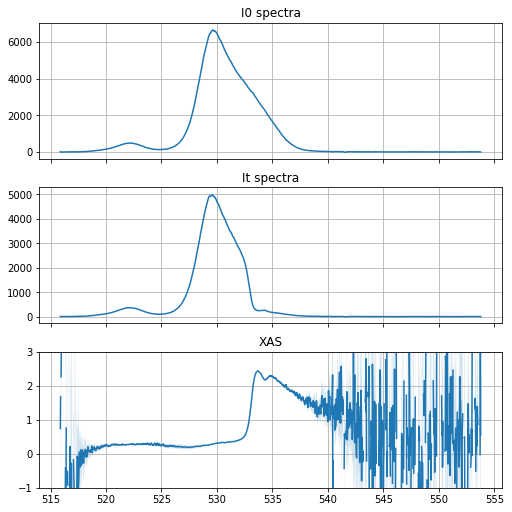

In [7]:
ds = v.from_run(runNB)  # load runNB
v.integrate(ds)  # integrate over the non-dispersive dimension 
v.removePolyBaseline(ds)  # remove baseline

xas = v.xas(ds, ds_ref, thickness=1, plot=True, xas_ylim=(-1, 3))
xas

The `xas` dataset created contains the averaged spectra of the reference `I0`, of the transmitted signal `It`, and the absorption coefficient -log(It / I0) / thickness. For each quantity, the standard deviation and standard error are calculated. The number of spectra used in the calculation are added as attributes.

## Beam size measurement with knife-edge

In [8]:
proposal = 2953
fields = ['newton', 'chem_X']  # chem_X is the manipulator used to move a blade through the beam.

runNB = 405

v.set_params(fields=fields)
v.X_RANGE = slice(0, 1550)
v.Y_RANGE = slice(15, 90)
ds = v.from_run(runNB)

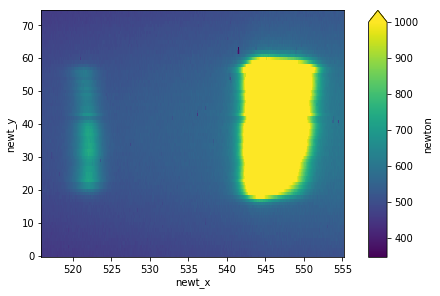

In [9]:
plt.figure()
ds['newton'].mean(dim='trainId').plot(vmax=1000)

fitting function: a*erfc(np.sqrt(2)*(x-x0)/w0) + b
w0 = (25.6 +/- 0.4) um
x0 = (-30.598 +/- 0.000) mm
a = 8.038647e+06 +/- 1.638269e+04 
b = 9.109166e+06 +/- 2.041594e+04 
fitting function: a*erfc(np.sqrt(2)*(x-x0)/w0) + b
w0 = (27.5 +/- 0.4) um
x0 = (-30.598 +/- 0.000) mm
a = 3.405624e+07 +/- 8.242170e+04 
b = 1.331917e+07 +/- 1.025471e+05 


(0.02746726107164219, 0.0004455003530353428)

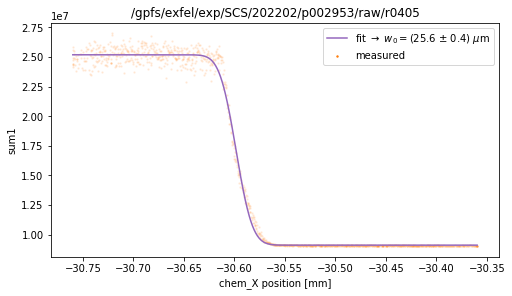

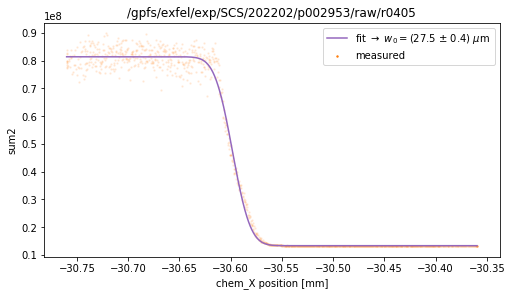

In [10]:
roi1 = [30, 430]
roi2 = [960, 1540]
ds['sum1'] = ds['newton'].isel(newt_x=slice(*roi1)).sum(dim=['newt_x', 'newt_y'])
ds['sum2'] = ds['newton'].isel(newt_x=slice(*roi2)).sum(dim=['newt_x', 'newt_y'])
tb.knife_edge(ds, axisKey='chem_X', signalKey='sum1', plot=True) # color 1
tb.knife_edge(ds, axisKey='chem_X', signalKey='sum2', plot=True) # color 2


## Energy calibration

The `calibrate` method determines the calibration coefficients to translate the
camera pixels into energy in eV. The Viking spectrometer is calibrated
using the beamline monochromator: runs with various monochromatized
photon energy are recorded and their peak position on the detector are
determined by Gaussian fitting. The energy vs. position data is then
fitted to a second degree polynomial.


energy calibration before: [0, 1, 0]
118
119
120
121
122
123
124
energy calibration after: [1.18294370e-05 8.08628533e-02 8.63298212e+02]


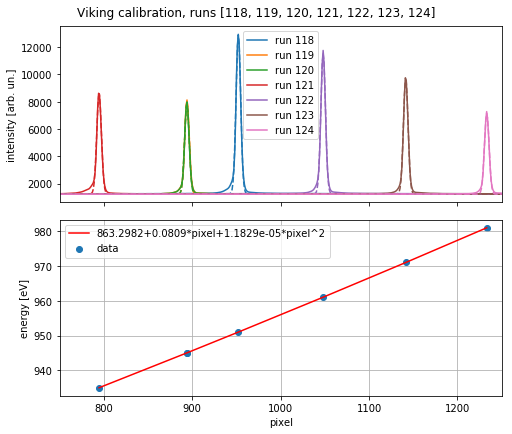

In [11]:
proposal = 2593
v = tb.Viking(proposal)
v.X_RANGE = slice(0, 1900)
v.Y_RANGE = slice(30, 75)

print('energy calibration before:', v.ENERGY_CALIB)
runs = list(range(118,125))

v.calibrate(runs, plot=True)
plt.xlim(750, 1250)

print('energy calibration after:', v.ENERGY_CALIB)
